<a href="https://colab.research.google.com/github/dafrie/fin-disclosures-nlp/blob/master/notebooks/CRO_Classification_Baseline.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Baseline models for CRO Classification

## Setup

In [ ]:
try:
  import google.colab
  is_running_in_colab = True
except:
  is_running_in_colab = False

if is_running_in_colab:
  # Load Google drive where the data and models are stored
  from google.colab import drive
  drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
############################## CONFIG ##############################
# Task config
TASK = "multi-label" #@param ["multi-label", "binary"]
CATEGORY_LEVEL = 'cro' #@param ["cro", "cro_sub_type_combined"]
MODEL_TYPE = "baseline" #@param ["baseline", "transformer"]
MODEL_NAME = "svm"

# Dataset config
FILTER_OP = True #@param { type: "boolean"}
SCENARIO = "realistic" #@param [ "optimistic", "efficient-realistic", "realistic"]

# Evaluation metric config. See for context: https://scikit-learn.org/stable/modules/generated/sklearn.metrics.f1_score.html
AVERAGING_STRATEGY = 'macro' #@param ["micro",  "macro", "weighted"]

RESULTS_FILE_NAME = f"{CATEGORY_LEVEL}_{TASK}_results.csv"

# To make the notebook reproducible (not guaranteed for pytorch on different releases/platforms!)
SEED_VALUE = 42

##################

# AP is equal to Precision/Recall AUC! See for discussion: https://github.com/scikit-learn/scikit-learn/issues/5992
SCORING_METRIC = 'average_precision' #@param ["average_precision",  "roc_auc"]

####################################################################
LOCAL_DIR = "/Users/david/Nextcloud/Dokumente/Education/Uni Bern/Master Thesis/Analyzing Financial Climate Disclosures with NLP/Methodology/"
COLAB_DIR = "/content/drive/MyDrive/fin-disclosures-nlp"

if SCENARIO == "optimistic":
  TRAIN_NEG_SAMPLING_STRATEGY = "None"
  TEST_NEG_SAMPLING_STRATEGY = "None"

elif SCENARIO == "efficient-realistic":
  TRAIN_NEG_SAMPLING_STRATEGY = "only_OP"
  TEST_NEG_SAMPLING_STRATEGY = "all"

elif SCENARIO == "realistic":
  TRAIN_NEG_SAMPLING_STRATEGY = "all"
  TEST_NEG_SAMPLING_STRATEGY = "all"


parameters = {
    "task": TASK,
    "category_level": CATEGORY_LEVEL,
    "model_type": MODEL_TYPE,
    "model_name": MODEL_NAME,
    "scenario": SCENARIO,
    "seed_value": SEED_VALUE,
}

In [ ]:
if is_running_in_colab:
  # Install transformers library + datasets helper
  !pip install transformers --quiet
  !pip install datasets --quiet
  !pip install optuna --quiet
  !python -m spacy download en_core_web_md

  # Latex for output
  ! apt install texlive-latex-recommended -qq
  ! apt install texlive-latex-extra -qq
  ! apt install dvipng -qq
  ! apt install cm-super -qq

  # Load repository

  !git clone https://github.com/dafrie/fin-disclosures-nlp.git    
  %cd /content/fin-disclosures-nlp
  !git pull


%load_ext autoreload
%autoreload 2

import sys
import os
import numpy as np
import pandas as pd
sys.path.append('..')

if is_running_in_colab:
  sys.path.append('.')

from data import constants
from data import cro_dataset
# This module depends on spacy's language models, need to restart the runtime to reload once downloaded.
try:
  from data import dataframe_preparation
except OSError:
  exit()
from data import dataframe_preparation
from data import evaluation

DIR = COLAB_DIR if is_running_in_colab else LOCAL_DIR
DATA_DIR = os.path.join(DIR, "data", "labels")
MODELS_DIR = os.path.join(DIR, "models", MODEL_TYPE)
RESULTS_DIR = os.path.join(DIR, 'results')
RESULTS_FILE_PATH = os.path.join(RESULTS_DIR, RESULTS_FILE_NAME)

✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_md')
texlive-latex-recommended is already the newest version (2017.20180305-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
texlive-latex-extra is already the newest version (2017.20180305-2).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
dvipng is already the newest version (1.15-1).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
cm-super is already the newest version (0.3.4-11).
0 upgraded, 0 newly installed, 0 to remove and 14 not upgraded.
fatal: destination path 'fin-disclosures-nlp' already exists and is not an empty directory.
/content/fin-disclosures-nlp
remote: Enumerating objects: 7, done.
remote: Counting objects: 100% (7/7), done.
remote: Compressing objects: 100% (1/1), done.
remote: Total 4 (delta 3), reused 4 (delta 3), pack-reused 0
Unpacking objects: 100% (4/4), done.
From https://github.com/dafrie/fin-disclosures-nlp
   d

In [ ]:
# Load/Initialize results file
results = evaluation.Results(RESULTS_FILE_PATH, parameters)

In [ ]:
train_docs, train_doc_labels, test_docs, test_doc_labels = cro_dataset.prepare_datasets(
    data_dir=DATA_DIR,
    task=TASK, 
    cro_category_level=CATEGORY_LEVEL, 
    should_filter_op=FILTER_OP, 
    train_neg_sampling_strategy=TRAIN_NEG_SAMPLING_STRATEGY, 
    test_neg_sampling_strategy=TEST_NEG_SAMPLING_STRATEGY, 
    seed_value=SEED_VALUE
)

Loaded dataset. Train: 27811, Test: 28209, Dim: 2


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.multiclass import OneVsRestClassifier

from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.metrics import make_scorer, average_precision_score, roc_auc_score

# Custom scorer so we can pass in the averaging strategy
avg_scorer = make_scorer(average_precision_score if SCORING_METRIC == 'average_precision' else roc_auc_score, average=AVERAGING_STRATEGY)

svc_clf = SVC(probability=True, random_state=SEED_VALUE, class_weight="balanced") # Balanced: n_samples / (n_classes * np.bincount(y)). Since we are doing OneVsRest, this should be giving correct weights!
# Wrap with OvR in case of multi-label
multi_label_clf = OneVsRestClassifier(svc_clf)

pipeline_svm = Pipeline([
    ('bow', CountVectorizer(strip_accents = 'ascii')),
    ('tfidf', TfidfTransformer()),
    ('classifier', multi_label_clf if TASK == "multi-label" else svc_clf),
     ])

# Parameters to tune automatically with a grid search
# Note: The nested estimator is accessible via the __estimator identifier
param_svm = [
  {
      'bow__tokenizer': [dataframe_preparation.spacy_tokenizer],
      'bow__stop_words': ['english'],
      'bow__ngram_range': [(1, 1), (1, 2)],
      'bow__max_features': [50, 500],
      'tfidf__use_idf': [True], 
      'classifier__estimator__C' if TASK == "multi-label" else 'classifier__C': [1, 10, 100], 
      'classifier__estimator__kernel' if TASK == "multi-label" else 'classifier__kernel': ['linear', 'rbf']},
]

grid_clf = GridSearchCV(
    pipeline_svm,
    param_grid=param_svm,
    refit=True,
    n_jobs=-1, 
    scoring=avg_scorer,
)

# Grid search fitting
grid_clf.fit(train_docs, train_doc_labels)

/usr/local/lib/python3.6/dist-packages/sklearn/feature_extraction/text.py:385: UserWarning: Your stop_words may be inconsistent with your preprocessing. Tokenizing the stop words generated tokens ['whereaft'] not in stop_words.
  'stop_words.' % sorted(inconsistent))


GridSearchCV(cv=None, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('bow',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        pr

In [ ]:
cv_results = pd.DataFrame(grid_clf.cv_results_)

print(f"Best {SCORING_METRIC} score: {grid_clf.best_score_}")
print(f"Best params: \n{grid_clf.best_params_}")

Best average_precision score: 0.3719413984856332
Best params: 
{'bow__max_features': 500, 'bow__ngram_range': (1, 1), 'bow__stop_words': 'english', 'bow__tokenizer': <function spacy_tokenizer at 0x7ffa61384158>, 'classifier__estimator__C': 1, 'classifier__estimator__kernel': 'rbf', 'tfidf__use_idf': True}


In [ ]:
# train_preds = grid_clf.predict(train_docs)
train_preds_prob = grid_clf.predict_proba(train_docs)

,ROC AuC,PR AuC
0,0.99962,0.971653


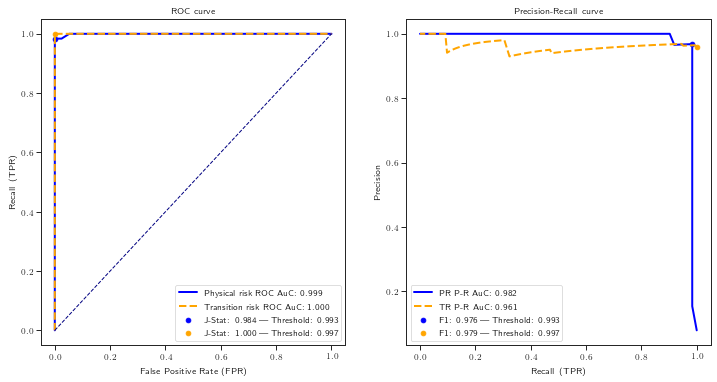

In [ ]:
train_threshold_moving_report = os.path.join(RESULTS_DIR, "figures", f"{CATEGORY_LEVEL}_{TASK}_{SCENARIO}_{MODEL_NAME}_train_threshold.pdf")
train_eval_scores, best_roc_threshold, best_pr_threshold = evaluation.threshold_moving_report(train_doc_labels, train_preds_prob, export_path=train_threshold_moving_report)
results.log_experiment(train_eval_scores, prefix="train")
results.log_experiment({ "best_pr_threshold": best_pr_threshold.values(), "best_roc_threshold": best_roc_threshold.values()}, prefix="train")
train_eval_scores

# Evaluation on Test

In [ ]:
# Predict for test
test_preds_prob = grid_clf.predict_proba(test_docs)

Using threshold values dict_values([0.9928000524087701, 0.996889304427884])
              precision    recall  f1-score   support

          PR       0.71      0.19      0.30        26
          TR       0.44      0.11      0.17        37

   micro avg       0.56      0.14      0.23        63
   macro avg       0.58      0.15      0.24        63
weighted avg       0.56      0.14      0.23        63
 samples avg       0.00      0.00      0.00        63



/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in samples with no predicted labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/_classification.py:1272: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in samples with no true labels. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


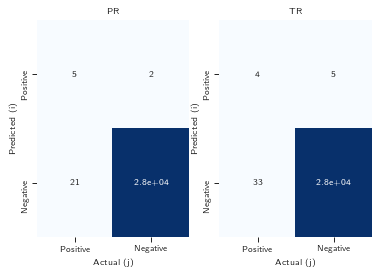

,ROC AuC,PR AuC,F1,Report,CMS
0,0.981598,0.330988,0.238472,"{""PR"": {""precision"": 0.7142857142857143, ""reca...","[[[5, 2], [21, 28181]], [[4, 5], [33, 28167]]]"


In [ ]:
test_eval_report = os.path.join(RESULTS_DIR, 'figures', f"{CATEGORY_LEVEL}_{TASK}_{SCENARIO}_{MODEL_NAME}_test_report.pdf")
test_eval_scores = evaluation.test_evaluation_report(test_doc_labels, test_preds_prob, best_pr_threshold.values(), averaging=AVERAGING_STRATEGY, export_path=test_eval_report)
results.log_experiment(test_eval_scores, prefix="test")
test_eval_scores

In [ ]:
import pickle

SAVE_MODEL = False

if SAVE_MODEL:
    with open(os.path.join(MODELS_DIR), f" {TASK}_svm_{CATEGORY_LEVEL}.pkl", 'wb') as f:
        grid_clf.label_list = label_list
        pickle.dump(grid_clf, f, 4)